# Home Credit Default Risk Predictor

This notebook addresses the Home Credit Default Risk Kaggle Problem. The primary objective is to predict, with the greatest accuracy possible, whether a loan will default. 

The training dataset available to us is of size 307511 rows 122 columns. We do have seperate test dataset but since this is a live competetion dataset we do not have labels for test dataset. So for the purpose of testing our prediction and validating the results we need to divide our training dataset to carve out dev-test dataset.

% of defaulted loans vs total loan is highly skewed. Hence we have decided to use ROC AUC metric to measure our classifiers with realistic target of achiving 65% accuracy. We also evaluate precision and recall to guage how our model fairs in conventional metrices

Prerequisite: Please download data files from below url to "input.nosync" folder created at same level as this notebook. You can change the folder name by modifying value of variable "input_dir" under "Global_configurations" section

https://www.kaggle.com/c/home-credit-default-risk/data

### Imports

In [1]:
# all the imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import pprint
import copy
import seaborn as sns
from scipy.stats import itemfreq

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, Imputer, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn import metrics

/Users/gauravdesai/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/gauravdesai/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Global configurations

In [2]:
warnings.filterwarnings('ignore') # No warnings displayed
pp = pprint.PrettyPrinter(indent=4) # tab is set to 4 spaces while printing
input_dir = 'input.nosync' # Sub directory where data files are stored

### Check data files

First lets ensure we have required files saved on our machine. If data files not found then we halt the notebook execution.

In [3]:
# List input files, if not available please download from below url inot a /input.nosync folder
input_files = os.listdir(input_dir)
if input_files is None or len(input_files) < 10 :
    raise Exception('You do not have all the files in {} directory'.format(input_dir))

print('You have all the input files. We can proceed further.')
print('Here are the data files\n')
pp.pprint(input_files)

You have all the input files. We can proceed further.
Here are the data files

[   'application_test.csv',
    '.DS_Store',
    'HomeCredit_columns_description.csv',
    'POS_CASH_balance.csv',
    'credit_card_balance.csv',
    'installments_payments.csv',
    'application_train.csv',
    'bureau.csv',
    'previous_application.csv',
    'bureau_balance.csv',
    'sample_submission.csv']


### Read data files

Here, we read our primary dataset "application_train.csv". As noted above and shown below, the dataset is of moderate size with 307,511 samples. The data is relatively wide with 122 features presented. Notably, we use the pandas library to handle reading our csv, as the data contains a mixute of numerical and categorical data. Using the pd.head() function we provide a view into the data, which demonstrate these features. It is also notable that some null/Nan values are present. We evaluated methods of handling Nan features including automatic handling/dropping and median imputation. The presence of the Nan values did not prevent us from reaching our goal of .65 as we will see.

In [4]:
# Read application_train.csv
app_train = pd.read_csv(input_dir+'/application_train.csv')
print('Training data shape (Before Split): ', app_train.shape)
print('Top 5 rows from file are:')
app_train.head()

Training data shape (Before Split):  (307511, 122)
Top 5 rows from file are:


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Split Training Data into Training and Testing Data

Below we allocate a training and testing split and set the random state to ensure repeatability. To accomplish this, we use the sklearn's train_test_split function. We reserve 20% of the data for testing, which results in training and test sets of the size printed. We also remove the target feature, and later down in the notebook remove the ID feature so that our classifiers do not unnecessarily try to correlate them to outcome.

In [5]:
# Move Target column to seperate variable
app_train_labels = app_train['TARGET']
app_train = app_train.drop('TARGET', axis=1)

# split the training dataset into training (80%) and testing (20%)
split_ratio = 0.20
app_train_data, app_test_data, train_labels, test_labels = train_test_split(
    app_train, app_train_labels, test_size = split_ratio, random_state = 23 )

# copy ID column to separate variable so that it can be easily used to joinmultiple DataFrames
app_train_data_skid_curr = app_train_data['SK_ID_CURR']
app_test_data_skid_curr = app_test_data['SK_ID_CURR']

In [6]:
print('Training data shape: ', app_train_data.shape)
print('Training label shape: ', train_labels.shape)
print('Test data shape: ', app_test_data.shape)
print('Test label shape: ', test_labels.shape)

Training data shape:  (246008, 121)
Training label shape:  (246008,)
Test data shape:  (61503, 121)
Test label shape:  (61503,)


### Data Cleaning and Preprocessing

Lets clean the data and create new features as per the EDA findings.
As a first step, lets create a generic function to replace any specific abnormal value in given data frame

In [7]:
def replace_anamoly_add_indicator(data, data_column_name, search_value, replacement_value=np.nan
                                  ,new_column_prefix='ANOMALY_'):
    """ Replaces specific value in a column of dataframe with replacement value. 
        Prior to this replacement it also creates an indicator column with a name similar
        to original column so that classifier would know which values were modified 
        and whether classifier can use this information for classification
        
        Args:
            data: DataFrame in which values need to be searched and replaced
            data_column_name: column name in DataFrame where values to be searched and replaced
            search_value: value to be searched and replaced in DataFrame column
            
        Kwargs:
            replacement_value: value to be replaced in place of search_value. Defaults to NaN
            new_column_prefix: Prefix to be used for creation of indicator column
            
        Returns:
            DataFrame with search value replaced and new indicator column created      
    """
    new_column_name = new_column_prefix + data_column_name
    data[new_column_name] = data[data_column_name] == search_value
    data[data_column_name].replace({search_value: replacement_value}, inplace = True)
    
    return data

#### DAYS_EMPLOYED

From EDA we know DAYS_EMPLOYED has unpracticle high value of 365243. Lets replace it with NaN

In [8]:
app_train_data = replace_anamoly_add_indicator(app_train_data,'DAYS_EMPLOYED',365243)
app_test_data = replace_anamoly_add_indicator(app_test_data,'DAYS_EMPLOYED',365243)

#### DAYS_LAST_PHONE_CHANGE

From EDA we know that DAYS_LAST_PHONE_CHANGE value of within last 1000 show stronger correlation than rest of value range. May be chances of fraud or more if person has recently changed the phone. So lets create new feature for this information.

In [9]:
#Looks like first 1000 days mean something, so lets add this variable in main training and test data set
print('Shape before adding column',app_train_data.shape,app_test_data.shape)
app_train_data['RECENT_DAYS_LAST_PHONE_CHANGE']=(app_train_data['DAYS_LAST_PHONE_CHANGE']*-1)<1000
app_test_data['RECENT_DAYS_LAST_PHONE_CHANGE']=(app_test_data['DAYS_LAST_PHONE_CHANGE']*-1)<1000
print('Shape after adding column',app_train_data.shape,app_test_data.shape)

Shape before adding column (246008, 122) (61503, 122)
Shape after adding column (246008, 123) (61503, 123)


#### Replacing missing values

As we found out during EDA, out of 68 columns having missing values 58 columns have more than 3% difference between % of missing values for Target = 0 vs Target = 1
Hence this could be significant information to predict Target. So while we impute the Nulls with 0 we want to capture that these values were Null in an indicator column so that our classifier can make use of this knoledge.

For this step first we create a generic method replace_null_add_indicator which can operate on both training and test dataset

In [10]:
#Change Null to 0's and add indicator column for each column having Null value
def replace_null_add_indicator(data):
    '''
    Lists all the columns in DataFrame having nulls, creates indicator column per data column 
    having null value, and then finally replaces the nulls with 0
    
    Args:
        data: DataFrame which needs to be inspected for nulls
        
    Retursn:
        Nothing, just replaces the nulls with 0 and adds indicator column in input DataFrame
        i.e. input DataFrame is changed 'inplace'
    
    '''
    missing_values = data.isnull().sum()
    columns = list(data.columns)

    for i,missing_count in enumerate(missing_values):
        if missing_count > 0:
            original_column_name = columns[i]
            indicator_column_name = 'Null_Indicator_'+original_column_name 
            data[indicator_column_name] = data[original_column_name].isnull()
            data[original_column_name].fillna(value=0,inplace=True)

In [11]:
replace_null_add_indicator(app_train_data)
print('After creating indicator columns, Training Data shape={}'
      .format(app_train_data.shape))
print('Lets check how many columns in training data still have NULL = {}'
      .format(app_train_data.isnull().sum().sum()))

#Perform same operation on test data
replace_null_add_indicator(app_test_data)
print('After creating indicator columns, Tesy Data shape={}'
      .format(app_test_data.shape))
print('Lets check how many columns in test data still have NULL = {}'
      .format(app_test_data.isnull().sum().sum()))

After creating indicator columns, Training Data shape=(246008, 191)
Lets check how many columns in training data still have NULL = 0
After creating indicator columns, Tesy Data shape=(61503, 189)
Lets check how many columns in test data still have NULL = 0


### Feature Engineering

As per our findings from EDA, three EXT_SOURCE and their higher degree polynomials show noticable correlation with Target. Hence lets create these polynomial features for training and test data.

In [12]:
# add EXT_SOURCE columns polynomials in main data
ext_columns = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

# Create seperate DataFrame of just EXT_SOURCE_ columns
app_train_data_ext = pd.DataFrame(data=app_train_data, columns=ext_columns)
app_train_data_ext.fillna(0, inplace=True)
app_test_data_ext = pd.DataFrame(data=app_test_data, columns=ext_columns)
app_test_data_ext.fillna(0, inplace=True)

# Fit a Polynomial Feature creator of degree 3 and fit over training data
poly_transformer = PolynomialFeatures(degree = 3)
poly_transformer.fit(app_train_data_ext)

# Transform both training and test data using polynomial transformer
app_train_data_ext=poly_transformer.transform(app_train_data_ext)
app_test_data_ext=poly_transformer.transform(app_test_data_ext)

# Get list of higher order features created by polynomial transformer
ploy_feature_names = poly_transformer.get_feature_names(input_features = ext_columns)
print('ploy_feature_names=')
pp.pprint(ploy_feature_names)

# Convert the transformed polynomial data object to Panda DataFrame for further processing
app_train_data_ext = pd.DataFrame(app_train_data_ext, 
                             columns = ploy_feature_names)
app_test_data_ext = pd.DataFrame(app_test_data_ext, 
                             columns = ploy_feature_names)

# ADD SK_ID_CURR column into EXT_SOURCE DataFrame. 
# This SK_ID_CURR column acts as a key to merge these polynomial DataFrames
# to original training and test DataFrames
app_train_data_ext = app_train_data_ext.assign(SK_ID_CURR=app_train_data_skid_curr.values)
app_test_data_ext  = app_test_data_ext.assign(SK_ID_CURR=app_test_data_skid_curr.values)

# Drop original EXT_SOURCE_ (first order) columns from polynomial DataFrame
# Since these columns exists in our original training dataser, while merging 
# having common columns other than key column create problem
app_train_data_ext = app_train_data_ext.drop(ext_columns,axis=1)
app_test_data_ext  = app_test_data_ext.drop(ext_columns,axis=1)

# Just to be sure, put training and test data set into Panda DataFrames
app_train_data=pd.DataFrame(data=app_train_data)
app_test_data=pd.DataFrame(data=app_test_data)

# Merge EXT_SOURCE_ DataFrames back to training and test datasets by joininh on SK_ID_CURR key
app_train_data = app_train_data.merge(app_train_data_ext, on = 'SK_ID_CURR', how = 'left')
app_test_data  = app_test_data.merge(app_test_data_ext, on = 'SK_ID_CURR', how = 'left')

ploy_feature_names=
[   '1',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'EXT_SOURCE_1^2',
    'EXT_SOURCE_1 EXT_SOURCE_2',
    'EXT_SOURCE_1 EXT_SOURCE_3',
    'EXT_SOURCE_2^2',
    'EXT_SOURCE_2 EXT_SOURCE_3',
    'EXT_SOURCE_3^2',
    'EXT_SOURCE_1^3',
    'EXT_SOURCE_1^2 EXT_SOURCE_2',
    'EXT_SOURCE_1^2 EXT_SOURCE_3',
    'EXT_SOURCE_1 EXT_SOURCE_2^2',
    'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
    'EXT_SOURCE_1 EXT_SOURCE_3^2',
    'EXT_SOURCE_2^3',
    'EXT_SOURCE_2^2 EXT_SOURCE_3',
    'EXT_SOURCE_2 EXT_SOURCE_3^2',
    'EXT_SOURCE_3^3']


Lets pause and see how many more columns we have now

In [13]:
print('Training data shape: ', app_train_data.shape)
print('Test data shape: ', app_test_data.shape)

Training data shape:  (246008, 208)
Test data shape:  (61503, 206)


### Data Preprocessing

Now that we have taken care of our EDA findings, lets move to Data Preprocessing. Here we will use standard processes like Scaling, PCA etc. to preprocess our data for optimum performance by our models.

#### Remove ID columns
Before we do any data pre processing, lets remove ID columns. These columns have importance till we want to join multiple data sets but have no correlation with Target and hence it is best to remove these columns so that our model does not waste time to find any correlation between ID columns and Target variable

In [14]:
# Remove ID column so that it does not interfere with PCA and regresison models
app_train_data = app_train_data.drop('SK_ID_CURR', axis=1)
app_test_data = app_test_data.drop('SK_ID_CURR', axis=1)

print('Training SK ID data shape: ', app_train_data_skid_curr.shape)
print('Test SK ID data shape: ', app_test_data_skid_curr.shape)
print('Training Features shape: ', app_train_data.shape)
print('Testing Features shape: ', app_test_data.shape)

Training SK ID data shape:  (246008,)
Test SK ID data shape:  (61503,)
Training Features shape:  (246008, 207)
Testing Features shape:  (61503, 205)


#### Convert Categorical Columns to Numeric

Wherever number of distinct categories in a feature are 2, we don't need to create indicator column for each of the two values. So we will use Label Encoding for such columns. In Label Encoding no new column is created, only the categories are converted to integers.

However for features with more than 2 distinct categories, if we use Label Encoding then it creates perceived hierarchy or relation between different categories. Hence for features with more than two distinct categories we use One-Hot encoding. This process will create new column for each distinct category

In [15]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in list(app_train_data.columns):
    if app_train_data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train_data[col].unique())) <= 2:
            # Train Label Encoder on the training data
            le.fit(app_train_data[col])
            # Transform both training and testing data
            app_train_data[col] = le.transform(app_train_data[col])
            app_test_data[col] = le.transform(app_test_data[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('{} columns were label encoded'.format(le_count))
print('Training Features shape: ', app_train_data.shape)
print('Testing Features shape: ', app_test_data.shape)

3 columns were label encoded
Training Features shape:  (246008, 207)
Testing Features shape:  (61503, 205)


Now that we have finished with Label Encoding, lets perform One-Hot encoding on rest of the categorical features. For this, we again rely on pandas API.

In [16]:
app_train_data = pd.get_dummies(app_train_data)
app_test_data = pd.get_dummies(app_test_data)

print('Training Features shape: ', app_train_data.shape)
print('Testing Features shape: ', app_test_data.shape)

Training Features shape:  (246008, 334)
Testing Features shape:  (61503, 331)


#### Align Training And Test DataSets

As we finish Adding more features into Training and Test DataSets we notice that Training DataSet has 334 columns whereas Test DataSet has 331 columns. This happens because few our Data Cleaning processes like replacing Nulls with indicator column and few of the Data Preprocessing steps like One-Hot encoding look at tge actual data in a given dataset before and depending on the data number of columns created in that step may very for each dataset.

e.g. Test DataSet does not have Null in any column whereas Training DataSet has Null in the same column, then we will create extra Null indicator column in Training but not in Test DataSet.

Similarly in One-Hot encoding if Test DataSet has one less category then one less column will be created. 

But having different number of columns across Training and Test DataSets will not work with our classifiers. Hence we need to align our training and test datasets so that we keep only common columns and drop others. 

In [17]:
# Align Training and Test Data Sets to bring parity in number of columns
app_train_data, app_test_data = app_train_data.align(app_test_data, join = 'inner', axis = 1)
print('Training Features shape: ', app_train_data.shape)
print('Testing Features shape: ', app_test_data.shape)

Training Features shape:  (246008, 331)
Testing Features shape:  (61503, 331)


### Scaling

Now that we have cleaned up and alligned Training and Test Data we notice that not all columns are measured in comparable scale. As we saw during EDA, some features like DAYS_BIRTH are mesured in days and hence have very large range whereas some features like CNT_CHILDREN have very small range in terms of absolute numbers. Such kind of disparity in variability misleads the PCA and classifiers. Hence we need to bring all the columns to uniform scale and capture true variability.

For the purpose of scaling we use Min-Max scaling with feature range of 0 to 1 so that all the features are fit into same range so that their respective variability can be easily compared.

In [18]:
scaler = MinMaxScaler(feature_range = (0, 1))
app_train_data = scaler.fit_transform(app_train_data)
app_test_data = scaler.transform(app_test_data)

Notably, we did attempt other feature engineering, but we did not see drastically changed results. Some efforts included using ratios of components. Dropping components after identifying the least influential by using LASSO linear regression methods, and different imputation strategies like the mean. We suspect that the lack of success with our other feature engineering efforts may be the result of a confluence of factors including the presence of Nan values and the necessity for highly specialized domain expertise.

In [19]:
# get optimum PCA for faster execution
cover_variance = .95
def get_optimum_pca(data, cover_variance=cover_variance):
    # Start with some large PCA number to speed up the calculation
    start_pca_no = 100
    
    #increement by some small number
    change_no_by = 20
    
    #max number of iterations to avoid infinite loops
    max_iter = 10
    
    iter_counter = 1
    current_pca_no = start_pca_no
    
    while True:
        
        pca = PCA(n_components=current_pca_no)
        pca.fit(data)
        var_ratios = pca.explained_variance_ratio_
        var_ratios_cum_sum = [sum(var_ratios[:i+1]) for i in range(len(var_ratios))]
        
        print('Iteration {} explains {} variance with {} PCA components'
              .format(iter_counter, var_ratios_cum_sum[-1], current_pca_no))
        #print(var_ratios)
        #print(var_ratios_cum_sum)
        
        if var_ratios_cum_sum[-1] >= cover_variance:
            for i, ration_sum in enumerate(var_ratios_cum_sum):
                if ration_sum >= cover_variance:
                    return i+1
                    
        iter_counter = iter_counter + 1
        if iter_counter > max_iter:
            print('Did not reach targetted covariance ratio {} in {} iterations'
                  .format(cover_variance, max_iter))
            print('Current calculated PCA number {} will cover {} % variance'
                  .format(current_pca_no, var_ratios_cum_sum[-1]))
            break
            
        current_pca_no = current_pca_no + change_no_by

    return current_pca_no

pca_no = get_optimum_pca(app_train_data)
print('To cover variance of {} we will use PCA with {} components'
      .format(cover_variance,pca_no))

Iteration 1 explains 0.981567621145407 variance with 100 PCA components
To cover variance of 0.95 we will use PCA with 65 components


In [20]:
# Reduce dimentions of training and test data using PCA
pca = PCA(n_components=pca_no)
app_train_data_pca = pca.fit_transform(app_train_data)
app_test_data_pca = pca.transform(app_test_data)

In [21]:
# After PCA lets see the shape
print(app_train_data_pca.shape)
print(app_test_data_pca.shape)

(246008, 65)
(61503, 65)


In [22]:
#This tuple will be used by all classifiers

#PCA
train_test_data_pca = {
    'train_data'   : app_train_data_pca,
    'test_data'    : app_test_data_pca,
    'train_labels' : train_labels,
    'test_labels'  : test_labels
}

#Non PCA
train_test_data_all = {
    'train_data'   : app_train_data,
    'test_data'    : app_test_data,
    'train_labels' : train_labels,
    'test_labels'  : test_labels
}

train_test_data = train_test_data_pca

As noted in the output, we selected our number of PCA components to cover .80 of the variance. This covers a significant amount of the variance while reducing our feature count to 21. This covers a significant amount of the variance while also greatly reducing our computational task. 

We next start to build our analysis tools and crate baseline measures. As a first measure, we create the Stat_Holder class, which begins to abstract away some of our coding tasks. The Stat_holder provides information about PCA components and parameters along with our target accuracy in a human readable format

In [23]:
class Stat_Holder:
    
    def __init__(self, pca_component_no, classifier_name, classifier_params
                 , roc_auc_score, recall_score, precision_score): 
        self.pca_component_no = pca_component_no
        self.classifier_name = classifier_name
        self.classifier_params = classifier_params
        self.roc_auc_score = roc_auc_score
        self.recall_score = recall_score
        self.precision_score = precision_score
        
    def __str__(self):
        return '{pca_component_no='+ str(self.pca_component_no) +\
                ' classifier_name=' + str(self.classifier_name) +\
                ' classifier_params=' + str(self.classifier_params) +\
                ' roc_auc=' + str(self.roc_auc_score) +\
                ' recall=' + str(self.recall_score) +\
                ' precision=' + str(self.precision_score) +\
                '}'
        
    def __lt__(self, other):

        
        # sort decending by roc_auc_score
        return self.roc_auc_score > other.roc_auc_score 
# End of class Stat_Hlder   

def sort_print_stats(stats,top=10):    
    stats=sorted(stats)
    print_stats(stats,top)

def print_stats(stats,top=10):
    print('\n')
    print('{:^6}{:^12}{:^40}{:^10}{:^30}{:^10}{:^10}'
          .format('Sr. No.','No. of PCA','Classifier','ROC AUC','Classifier Params', 'Recall', 'Precision'))
    print('_'*118)
    for index,stat in enumerate(stats[:top]):
        print('{:^6}{:^12}{:^40}{:>10.5}{:^30}{:>10.5}{:>10.5}'
              .format(index+1,stat.pca_component_no,stat.classifier_name
                      ,stat.roc_auc_score,stat.classifier_params,stat.recall_score,stat.precision_score))

We will first us several combinations of PCA and a Random Forest to get baseline predictions. This is achieved with our next layer of abstraction, which provides a number of functions that perform PCA transformations and fit and run our classifiers. Here, we use PCA counts of 1 through 5 and use 4 different classifiers. We also vary the hyperparameters of our models for several different mixes within these ranges. The classifiers used included: Decision tree, Kmeans, Gaussian, and KNN.

In [24]:
def get_estimater_name(clf):
    if type(clf).__name__ == 'GridSearchCV':
        estimater_name = 'GridSearchCV:'+ type(clf.estimator).__name__
    else:
        estimater_name = type(clf).__name__
    return estimater_name

def get_estimater_param(clf,clf_params):
    if type(clf).__name__ == 'GridSearchCV':
        for i,param in enumerate(clf_params.split(',')):
            if i > 0:
                parameters = parameters + ','
            parameters = param + '=' + str(clf.best_params_[param])    
    else:
        parameters = clf_params

    return parameters

def run_classifier(clf, train_data,train_labels,test_data,test_labels,pca_no,clf_params):
    positive_probability_threashold = .06 #.09 calculated
    '''
    print('Train Data Shape',train_data.shape)
    print('Train Label Shape',train_labels.shape)
    print('Test Data Shape',test_data.shape)
    print('Test Label Shape',test_labels.shape)
    '''
    clf = clf.fit(train_data,train_labels)
    
    test_labels_proba = clf.predict_proba(test_data)
    print('Test Labels Predicted Probability Shape', test_labels_proba.shape)
    test_labels_predicted = test_labels_proba[:,-1] > positive_probability_threashold
    test_labels_predicted.astype(int)
    
    #test_labels_predicted = clf.predict(test_data)
    '''
    print('Train Labels unique values',np.unique(train_labels))
    print('Test Labels unique values',np.unique(test_labels))
    print('Test Labels predicted unique values',np.unique(test_labels_predicted))
    '''
    
    roc_auc_score = metrics.roc_auc_score(test_labels,test_labels_predicted)
    recall_score = metrics.recall_score(test_labels,test_labels_predicted)
    precision_score = metrics.precision_score(test_labels,test_labels_predicted)
   
    st = Stat_Holder(pca_no,get_estimater_name(clf),get_estimater_param(clf,clf_params)
                     ,roc_auc_score,recall_score,precision_score)
    return st

def run_classifiers(min_PCA, max_PCA, classifier_list, train_test_data = train_test_data):
    stats = []
    
    train_data = train_test_data['train_data'][:limit_data,]
    train_labels = train_test_data['train_labels'][:limit_data,]
    test_data = train_test_data['test_data'][:limit_data]
    test_labels = train_test_data['test_labels'][:limit_data]
    
    #print(train_data.shape)
    #print(train_labels.shape)
    #print(test_data.shape)
    #print(test_labels.shape)
    
    for classifier in classifier_list:
        clf = classifier.get('clf')
        clf_params = classifier.get('params')
        print('{} started with params {}'.format(get_estimater_name(clf),clf_params))
        #print(clf)
        
        #print(clf_params)
        if min_PCA is None:
            st = run_classifier(clf, train_data,train_labels
                                        ,test_data,test_labels
                                ,'NA',clf_params)
            print(st)
            stats.append(st)
        else:
            pca_range = range(min_PCA,max_PCA+1)
            for pca_no in pca_range:
                    print('\tPCA {} started'.format(pca_no), end=" ")
                    pca = PCA(n_components = pca_no,copy = True)
                    train_data_pca = pca.fit_transform(train_data) 
                    test_data_pca = pca.transform(test_data) 

                    st = run_classifier(clf, train_data_pca,train_labels
                                        ,test_data_pca,test_labels
                                        ,pca_no,clf_params)
                    stats.append(st)
                    print('\tPCA {} completed'.format(pca_no))
                    #print_stats([st])
        print('{} completed'.format(get_estimater_name(clf)))
    return stats
    


In [25]:
all_stats=[] #stats across all algo, never overridden
stats = [] #stats for specific group, overridden for each group

minPCA = 1
maxPCA = 5
limit_data = None
classifiers = []
classifiers.append({'clf':DecisionTreeClassifier(max_depth=5), 'params':'max_depth=5'} )
classifiers.append({'clf':KMeans(n_clusters=5), 'params':'n_clusters=5'} )
classifiers.append({'clf':GaussianMixture(n_components=3), 'params':'n_components=3'} )
classifiers.append({'clf':KNeighborsClassifier(n_neighbors=3), 'params':'n_neighbors=3'} )
#classifiers
#stats=run_classifiers(minPCA,maxPCA,classifiers)
#all_stats.extend(stats)

After processing, we exmaine our top classifiers based on our ROC_AUC accuracy measure. Our top perfomers achieved our target accuracy metric of .65. Interestingly, although we met our metric and tested several different models, the data does not provide an especially high level of accuracy. Below we will examine some alternative methods and use different measures to attempt to analyze and augment our results.

In [26]:
sort_print_stats(stats,top=15)



Sr. No. No. of PCA                Classifier                ROC AUC        Classifier Params         Recall  Precision 
______________________________________________________________________________________________________________________


Again we utilize our abstraction process and shift our attention to Logistic Regression, Gradient Boosting, and Random Forest Classifiers. After evaulation, we do not see a change to our top performer.

In [27]:
limit_data = None
classifiers = []
classifiers.append({'clf':LogisticRegression(C = 0.1), 'params':'C = 0.1'} )
classifiers.append({'clf':LogisticRegression(C = 0.01), 'params':'C = 0.01'} )
classifiers.append({'clf':LogisticRegression(C = 0.001, n_jobs=-1), 'params':'C = 0.001'} )
classifiers.append({'clf':LogisticRegression(C = 0.0001), 'params':'C = 0.0001'} )
#classifiers.append({'clf':RandomForestClassifier(n_estimators = 50), 'params':'n_estimators = 50'} )
#classifiers.append({'clf':RandomForestClassifier(n_estimators = 100, n_jobs=1), 'params':'n_estimators = 100'} )
#classifiers.append({'clf':GradientBoostingClassifier(n_estimators = 20,max_depth=7,verbose=True), 'params':'n_estimators = 100'} )
#classifiers.append({'clf':GradientBoostingClassifier(n_estimators = 50,max_depth=4,verbose=True), 'params':'n_estimators = 100'} )


stats=run_classifiers(None,None,classifiers)
all_stats.extend(stats)
sort_print_stats(stats)

LogisticRegression started with params C = 0.1
Test Labels Predicted Probability Shape (61503, 2)
{pca_component_no=NA classifier_name=LogisticRegression classifier_params=C = 0.1 roc_auc=0.6592591027223522 recall=0.8166531604538088 precision=0.12515135521127635}
LogisticRegression completed
LogisticRegression started with params C = 0.01
Test Labels Predicted Probability Shape (61503, 2)
{pca_component_no=NA classifier_name=LogisticRegression classifier_params=C = 0.01 roc_auc=0.6553421869833277 recall=0.8249594813614263 precision=0.12278744383801224}
LogisticRegression completed
LogisticRegression started with params C = 0.001
Test Labels Predicted Probability Shape (61503, 2)
{pca_component_no=NA classifier_name=LogisticRegression classifier_params=C = 0.001 roc_auc=0.6253629733522065 recall=0.8968800648298217 precision=0.10803357899360633}
LogisticRegression completed
LogisticRegression started with params C = 0.0001
Test Labels Predicted Probability Shape (61503, 2)
{pca_component

In [28]:
# Summary of top 15 execution. 
sort_print_stats(all_stats,top=15)



Sr. No. No. of PCA                Classifier                ROC AUC        Classifier Params         Recall  Precision 
______________________________________________________________________________________________________________________
  1        NA                LogisticRegression              0.65926           C = 0.1               0.81665   0.12515
  2        NA                LogisticRegression              0.65534           C = 0.01              0.82496   0.12279
  3        NA                LogisticRegression              0.62536          C = 0.001              0.89688   0.10803
  4        NA                LogisticRegression               0.5001          C = 0.0001                 1.0  0.080271


In [29]:
limit_data = None
clusters = {'n_clusters':list(range(8,10))}
depths = {'max_depth':list(range(5,7))}
components = {'n_components':list(range(5,6))}
neighbors = {'n_neighbors':list(range(5,6))}
#Cs = {'C':[.1,.01,.001,.0001]}
#estimators = {'n_estimators':[50,100,150]}

Cs = {'C':[.001]}
estimators = {'n_estimators':[50]}

classifiers = []
classifiers.append({'clf':GridSearchCV(estimator=KMeans(), param_grid=clusters), 'params':'n_clusters'} )
classifiers.append({'clf':GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=depths), 'params':'max_depth'} )
classifiers.append({'clf':GridSearchCV(estimator=GaussianMixture(verbose=1), param_grid=components), 'params':'n_components'} )
classifiers.append({'clf':GridSearchCV(estimator=KNeighborsClassifier(), param_grid=neighbors), 'params':'n_neighbors'})
classifiers.append({'clf':GridSearchCV(estimator=LogisticRegression(), param_grid=Cs), 'params':'C'} )
classifiers.append({'clf':GridSearchCV(estimator=RandomForestClassifier(), param_grid=estimators), 'params':'n_estimators'} )
classifiers.append({'clf':GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=estimators), 'params':'n_estimators'} )

#stats=run_classifiers(None,None,classifiers)
#all_stats.extend(stats) 
#sort_print_stats(stats)

In our final configurations, we see that our best model is our GradientBoostingClassifier, which allows us to achieve our target.

In [30]:
# Summary of top 15 execution. 
sort_print_stats(all_stats,top=15)



Sr. No. No. of PCA                Classifier                ROC AUC        Classifier Params         Recall  Precision 
______________________________________________________________________________________________________________________
  1        NA                LogisticRegression              0.65926           C = 0.1               0.81665   0.12515
  2        NA                LogisticRegression              0.65534           C = 0.01              0.82496   0.12279
  3        NA                LogisticRegression              0.62536          C = 0.001              0.89688   0.10803
  4        NA                LogisticRegression               0.5001          C = 0.0001                 1.0  0.080271


In the code block below, we explore some alternative methods of prediction and explore the alternative metrics of precision and recall. The method of prediction provided by the Acorn class is to aggregate the 'votes' of several classifers and find a consensus on the ultimate classification of the target feature. Notably, we use 3 or 5 classifiers to avoid tie votes. The theory behind this method is that the aggregation of predictions is likely to be more accurate than any single prediction. This principle has been demonstrated in prediction markets as well as with mathematical examples.
To test the point, we selected some of our lower performing classifers. The results below are interesting in that we obtain a relatively high precision and recall score with both being in the low 90s. In addition, we obtain a a ROC AUC score of .70 using a probability measure, which provides a performance boost without modification using three underperforming classifiers.

In [32]:
class Acorn():
    """Provides a way to aggregagte the outputs of 3 or 5 classifiers
        INIT:
            classifers: list, fitted classifer objects
            X: ndarray, numerical of features
    """
    
    def __init__(self, classifiers, X):
        self.classifiers = classifiers
        self.votes = [clf.predict(X) for clf in self.classifiers]
        self.election_results = None

    def _get_votes(self):
        # 3 and 5 clasifiers to avoid ties
        # aggregate classifier outputs into array organization
        if len(self.votes) == 3:
            return np.c_[self.votes[0], self.votes[1], self.votes[2]]
        if len(self.votes) == 5:
            return np.c_[self.votes[0], self.votes[1], self.votes[2], self.votes[3], self.votes[4]]
        else:
            print('number of classiefiers must be 3 or 5')

    def vote(self):
        vote_pool = self._get_votes()
        #collect aggregate votes and outline by position
        self.election_results = np.array([np.argmax(np.bincount(item)) for item in vote_pool])
        return self.election_results
    
    def spf_score(self, y, average='micro'):
        # confirm shape and print various metrics
        if np.shape(self.election_results) == np.shape(y):
            print('election_results counts: 0=',sum(self.election_results==0),'1=',sum(self.election_results==1))
            print('Score: {}\n'.format(np.sum(self.election_results == y)/np.shape(self.election_results)[0]))
            print('Precision:{} | Recall: {}'
                  .format(metrics.precision_score(y, self.election_results, average=average),
                          metrics.recall_score(y, self.election_results, average=average)
                         ))
            #print('F1 score: {}'.format(f1_score(y, self.election_results)))
    
    def roc_it(self, X, y, plot=False):
        p = np.array(None)
        d = 0
        for i, clf in enumerate(self.classifiers):
            if i == 0:
                p = clf.predict_proba(X)
            else:
                p = p + clf.predict_proba(X)
                d = i
        prob_pos = p/(d+1)
        prob_pos = np.array([prob_pos[i,x] for i, x in enumerate(np.argmax(prob_pos, axis=1))])
        
        #code adapted from matplotlib
        # print or graph roc curve based on probability metric
        if plot == True:
            fpr, tpr, _ = metrics.roc_curve(y, prob_pos)
            roc_auc = metrics.auc(tpr, fpr)
            plt.plot(tpr, fpr, color='orange',
                    lw=1.5, label='ROC Curve (area = %0.2f)' % roc_auc)
            plt.plot([0,1], [0,1], color='steelblue', lw=1, linestyle='--')
            plt.xlim([0.0,1.0])
            plt.ylim([0.0,1.0])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc='lower right')
            plt.show()
        else:
            print('ROC_AUC score: {}'.format(metrics.roc_auc_score(y, prob_pos)))
        return p/(d+1)

In [33]:
# set pca and fit/transform
pca = PCA(n_components = 5,copy = True)
train_data_pca = pca.fit_transform(app_train_data) 
test_data_pca = pca.transform(app_test_data) 

In [34]:
logreg = classifiers[4]['clf']
#logreg.fit(app_train_data, train_labels)
logreg.fit(train_data_pca , train_labels)
randtree = classifiers[5]['clf']
#randtree.fit(app_train_data, train_labels)
randtree.fit(train_data_pca , train_labels)
grad = classifiers[6]['clf']
#grad.fit(app_train_data, train_labels)
grad.fit(train_data_pca , train_labels)
   
#classifiers

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=0)

election_results counts: 0= 61503 1= 0
Score: 0.9197437523372843

Precision:0.9197437523372843 | Recall: 0.9197437523372843


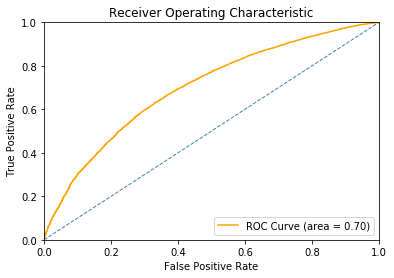

array([[0.93643518, 0.06356482],
       [0.96078262, 0.03921738],
       [0.83272201, 0.16727799],
       ...,
       [0.83435298, 0.16564702],
       [0.9350591 , 0.0649409 ],
       [0.90746734, 0.09253266]])

In [35]:
acorn = Acorn([logreg, randtree, grad],test_data_pca)
acorn.vote()
acorn.spf_score(test_labels)
acorn.roc_it(test_data_pca, test_labels, plot=True)

In the code and notes above, we demonstrated a process that hit our target accuracy metric. To accomplish, this we made some attempts at featuring engineering, but ultimately chose to reduce the dimenisonality after the feature engineering efforts were largely ineffective. We believe that this is due to the need for domain expertise to engineer additional features. As a result, we used PCA to reduce the dimensionality of our data and utilize only those features which captured the greatest amount of variance in our data. This technique proved effective and allowed us to achieve our goal of accuracy. Finally, we examined an alternative/experimental method of classification which aggregates the predictions of several classifiers to made a prediction. This method had interesting results in that the consensus prediction of three under-performing classifiers very nearly allowed us to achieve our accuracy goal without adjustment to our models.